
Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df_test = pd.read_csv("Battery_Testing_Data.csv") # may need to change the path
df_soc = pd.read_csv("SOC_OCV_MFCTT_2019.csv",sep = "\t")


Plot the Voltages as a function of the SOC

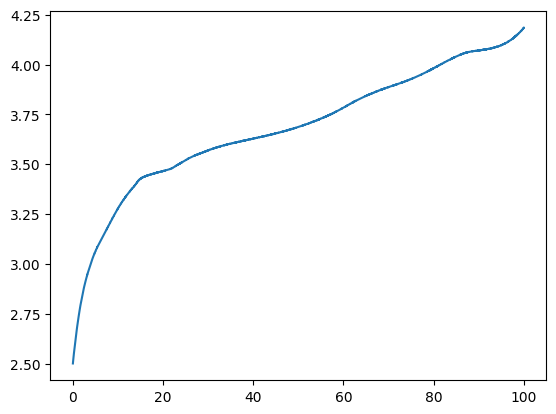

In [5]:
plt.figure()
plt.plot(df_soc['SOC'],df_soc['Ecell/V'])
plt.show()

Plot the Experimental Voltage as a function of time 

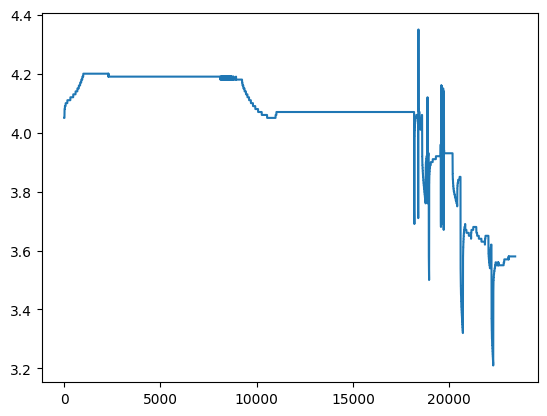

In [6]:
T = df_test['Time (s)']
Cur = df_test['Current (mA)']
Volt = df_test['Voltage (V)']
Temp = df_test['Temperature']
plt.figure()
plt.plot(T,Volt)
plt.show()

Zoom on the disharge

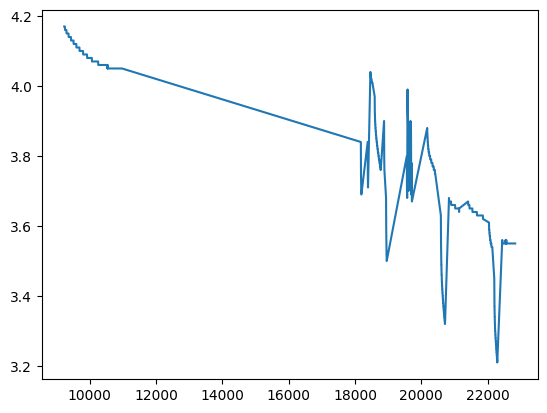

9238.0 4.17


In [7]:
Tclean = []
Voltc = []
Curc = []
for k in range(len(T)) :
    if Cur[k] < 0 :
        Tclean.append(T[k])
        Voltc.append(Volt[k])
        Curc.append(Cur[k])
plt.figure()
plt.plot(Tclean,Voltc)
plt.show()
print(Tclean[0],Voltc[0])

predicted SOC using coulomb technique 

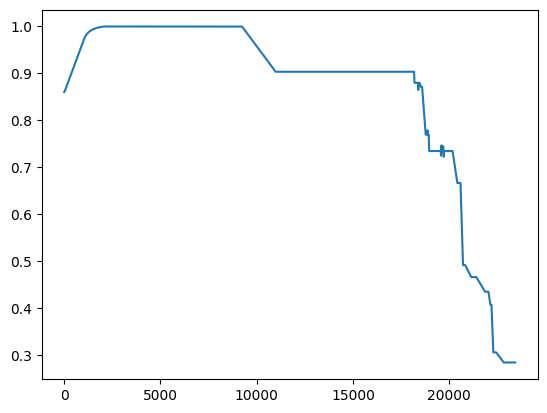

In [8]:
Z = [0.86]
Cur[0]=0
for k in range(len(T)-1) :
    Z.append(Z[k]+Cur[k]*(1/2500)/3600)

plt.figure()
plt.plot(T,Z)
plt.show()

In [9]:
R = 0.08/5
Cur = np.array(Cur)
OCV = []
Zmodif = np.round(df_soc['SOC'],2)
U = list(Zmodif/100)
for k in range(len(Cur)) :
    z = Z[k]
    z = np.round(z,2)
    
    OCV.append(df_soc['Ecell/V'][U.index(z)])
    
        
Voltpredict = R*Cur/1000+OCV


Only made changes to the code down here

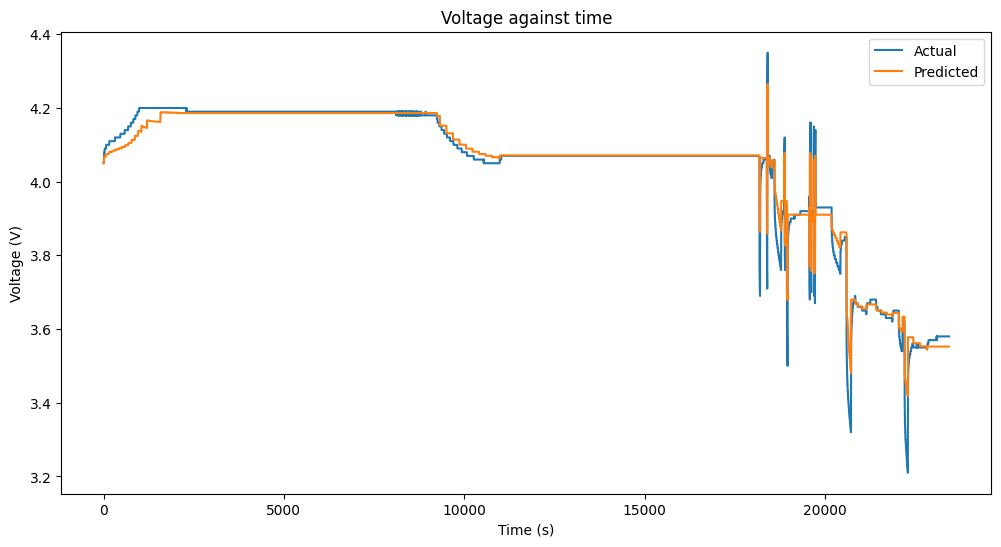

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(T,Volt, label="Actual")
plt.plot(T,Voltpredict, label="Predicted")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage against time")
plt.show()

ploting the absolute error 

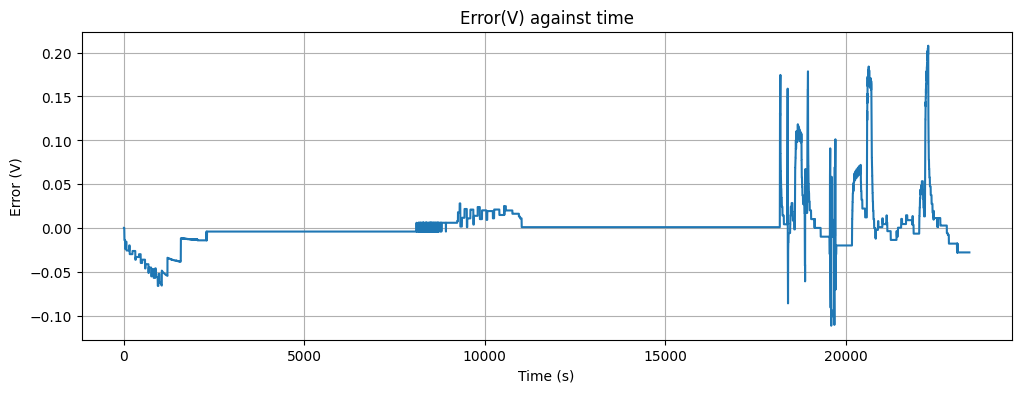

In [11]:
Error = []
for k in range(len(T)):
    Error.append(Voltpredict[k] - Volt[k] )

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(T,Error)
plt.xlabel("Time (s)")
plt.ylabel("Error (V)")
plt.title("Error(V) against time")
plt.grid()
plt.show()

plotting the relative error (%)

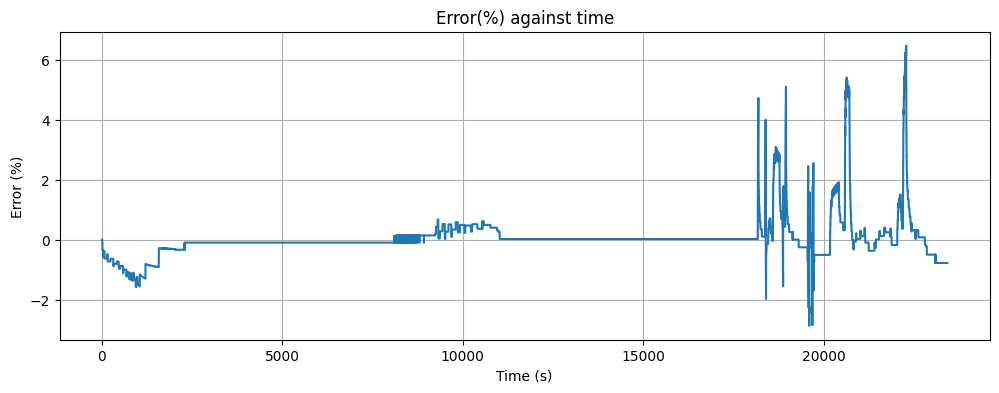

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
Error_percentage = Error / Volt*100
plt.plot(T,Error_percentage)
plt.xlabel("Time (s)")
plt.ylabel("Error (%)")
plt.title("Error(%) against time")
plt.grid()
plt.show()

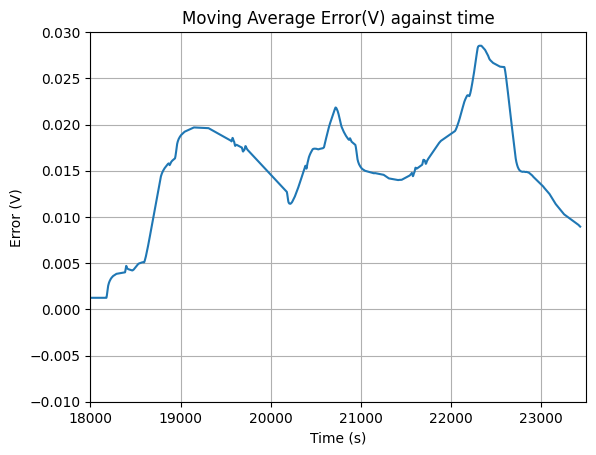

In [24]:
#moving average
#for every 10 time steps we calculate the average
af = pd.DataFrame({"error": Error, "time": T})
af['Rolling_avg'] = af['error'].rolling(window=2000).mean()
plt.plot(af['time'], af['Rolling_avg'])
plt.xlabel("Time (s)")
plt.ylabel("Error (V)")
plt.title("Moving Average Error(V) against time")
plt.xlim(18000,23500)
plt.ylim(-0.01,0.03)
plt.grid()
plt.show()